# Predicting SAT Mathematics Scores Using Supervised Learning: A Comprehensive Analysis of Multicollinearity and Model Performance

This project focuses on a **supervised learning regression task**. The goal is to build and evaluate machine learning models to predict the **Mathematics Mean SAT score** of schools in New York City based on the following features:
- **Critical Reading Mean Score**
- **Writing Mean Score**
- **Number of Test Takers**

This analysis aims to identify the most effective predictive models while addressing potential challenges such as multicollinearity and overfitting. The project evaluates multiple regression models, including:
- Linear Regression
- k-Nearest Neighbors (k-NN)
- Support Vector Regression (SVR)
- Decision Tree Regressor

By exploring and comparing these models, the project seeks to gain insights into predictive performance and highlight opportunities for improvement in the modeling process.

In [1]:
# Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and Dimensionality Reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Model Evaluation and Validation
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

# Multicollinearity Check
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 3D Plotting
from mpl_toolkits.mplot3d import Axes3D

# Pipeline
from sklearn.pipeline import Pipeline


## Data Loading, Cleaning and Preprocessing

## Data Description and Citation

### Data Source
The dataset used in this project is publicly available and contains **SAT performance data** for New York City schools from 2010. The data is sourced from NYC OpenData and can be accessed directly via the following link:
- [NYC SAT Results 2010](https://data.cityofnewyork.us/api/views/zt9s-n5aj/rows.csv?accessType=DOWNLOAD)

### Data Description
The dataset contains **460 rows** and **6 columns**, where each row corresponds to a school and each column represents a feature:
1. **DBN** (District Borough Number): Categorical identifier for schools.
2. **School Name**: Name of the school.
3. **Number of Test Takers**: Number of students who took the SAT at the school (numerical).
4. **Critical Reading Mean**: Average critical reading score (numerical).
5. **Mathematics Mean**: Average mathematics score (numerical).
6. **Writing Mean**: Average writing score (numerical).

### Data Cleaning Summary
After preprocessing, the dataset was reduced to **386 rows** by removing rows with missing values. Non-relevant categorical features (`DBN`, `School Name`) were excluded to focus on numerical features essential for modeling.

### Data Citation
> NYC OpenData. (n.d.). SAT College Board Results 2010. Retrieved from  
> https://data.cityofnewyork.us/api/views/zt9s-n5aj/rows.csv?accessType=DOWNLOAD

### Data Assumptions and Challenges
- Assumes the SAT scores are representative of school performance.
- The dataset is relatively small (386 rows after cleaning), which could affect model generalizability.


In [2]:
data = pd.read_csv('https://data.cityofnewyork.us/api/views/zt9s-n5aj/rows.csv?accessType=DOWNLOAD')

In [3]:
# Inspect the data
print(data.head())

      DBN                                     School Name  \
0  01M292  Henry Street School for International Studies    
1  01M448            University Neighborhood High School    
2  01M450                East Side Community High School    
3  01M458                   SATELLITE ACADEMY FORSYTH ST    
4  01M509                               CMSP HIGH SCHOOL    

   Number of Test Takers  Critical Reading Mean  Mathematics Mean  \
0                   31.0                  391.0             425.0   
1                   60.0                  394.0             419.0   
2                   69.0                  418.0             431.0   
3                   26.0                  385.0             370.0   
4                    NaN                    NaN               NaN   

   Writing Mean  
0         385.0  
1         387.0  
2         402.0  
3         378.0  
4           NaN  


In [4]:
print(data.shape)

(460, 6)


The data contains `460` rows and `6` columns. Each row corresponds to a school and each column corresponds to a feature of the school.

The DBN and School Name are categorical features, while the other columns are numerical features. We are given the number of test takers, the critical reading mean, mathematics mean and writing mean.

Let's inspect if there are any missing (nan) values in the data.

In [5]:
bad_rows = data[data.isnull().any(axis=1)]
print(bad_rows.shape)
print(bad_rows.head())

(74, 6)
       DBN                             School Name  Number of Test Takers  \
4   01M509                       CMSP HIGH SCHOOL                     NaN   
21  02M376                            NYC iSchool                     NaN   
37  02M445                Seward Park High School                     NaN   
41  02M473  YABC at Washington Irving High School                     NaN   
49  02M535                  Park West High School                     NaN   

    Critical Reading Mean  Mathematics Mean  Writing Mean  
4                     NaN               NaN           NaN  
21                    NaN               NaN           NaN  
37                    NaN               NaN           NaN  
41                    NaN               NaN           NaN  
49                    NaN               NaN           NaN  


There are 74 rows that contain bad data.

By looking at the head, it appears that if any of the columns (number of test takers, critical reading mean, mathematics mean, or writing mean) are missing, then all those columns are missing.

Let's verify this hypothesis by checking that those 4 columns are nan for every single of those 74 rows.

In [6]:
print(bad_rows.isnull().sum())

DBN                       0
School Name               0
Number of Test Takers    74
Critical Reading Mean    74
Mathematics Mean         74
Writing Mean             74
dtype: int64


We can see that the hypothesis is correct. We can drop these rows.

In [7]:
data = data.dropna()

Also, number of test takers should be an integer, so we will convert it to an integer.

In [8]:
assert (data['Number of Test Takers'] % 1 == 0).all() # Verify all the values are integers
data['Number of Test Takers'] = data['Number of Test Takers'].astype(int)

In [9]:
print(data.shape)

(386, 6)


We're now left with `386` rows.

Let's perform a sanity check by checking the minimum and maximum values in each of the columns.

In [10]:
print(data.describe())

       Number of Test Takers  Critical Reading Mean  Mathematics Mean  \
count             386.000000             386.000000        386.000000   
mean              103.658031             404.248705        412.935233   
std               145.264496              56.815631         64.990976   
min                 7.000000             291.000000        281.000000   
25%                35.000000             370.000000        372.000000   
50%                54.000000             392.500000        394.500000   
75%                92.750000             419.000000        429.750000   
max              1047.000000             674.000000        735.000000   

       Writing Mean  
count    386.000000  
mean     397.689119  
std       57.762584  
min      285.000000  
25%      364.000000  
50%      383.000000  
75%      414.000000  
max      678.000000  


Number of test takers is between 7 and 1047 per school, which is reasonable.

Test score means are between 285 and 735, which is also reasonable given that SAT scores for each section are between 200 and 800.

Let's also remove the categorical columns DBN and School Name, as they are not useful for our SL task.

In [11]:
data = data.drop(columns=['DBN', 'School Name'])

### Cleaned Data Summary

| Feature                  | Data Type | Description                                |
|--------------------------|-----------|--------------------------------------------|
| Number of Test Takers    | Integer   | Number of students taking the SAT         |
| Critical Reading Mean    | Float     | Mean SAT score for Critical Reading section|
| Mathematics Mean         | Float     | Mean SAT score for Math section           |
| Writing Mean             | Float     | Mean SAT score for Writing section        |


## Exploratory Data Analysis

Let's draw histograms of each of the four features.

array([[<Axes: title={'center': 'Number of Test Takers'}>,
        <Axes: title={'center': 'Critical Reading Mean'}>],
       [<Axes: title={'center': 'Mathematics Mean'}>,
        <Axes: title={'center': 'Writing Mean'}>]], dtype=object)

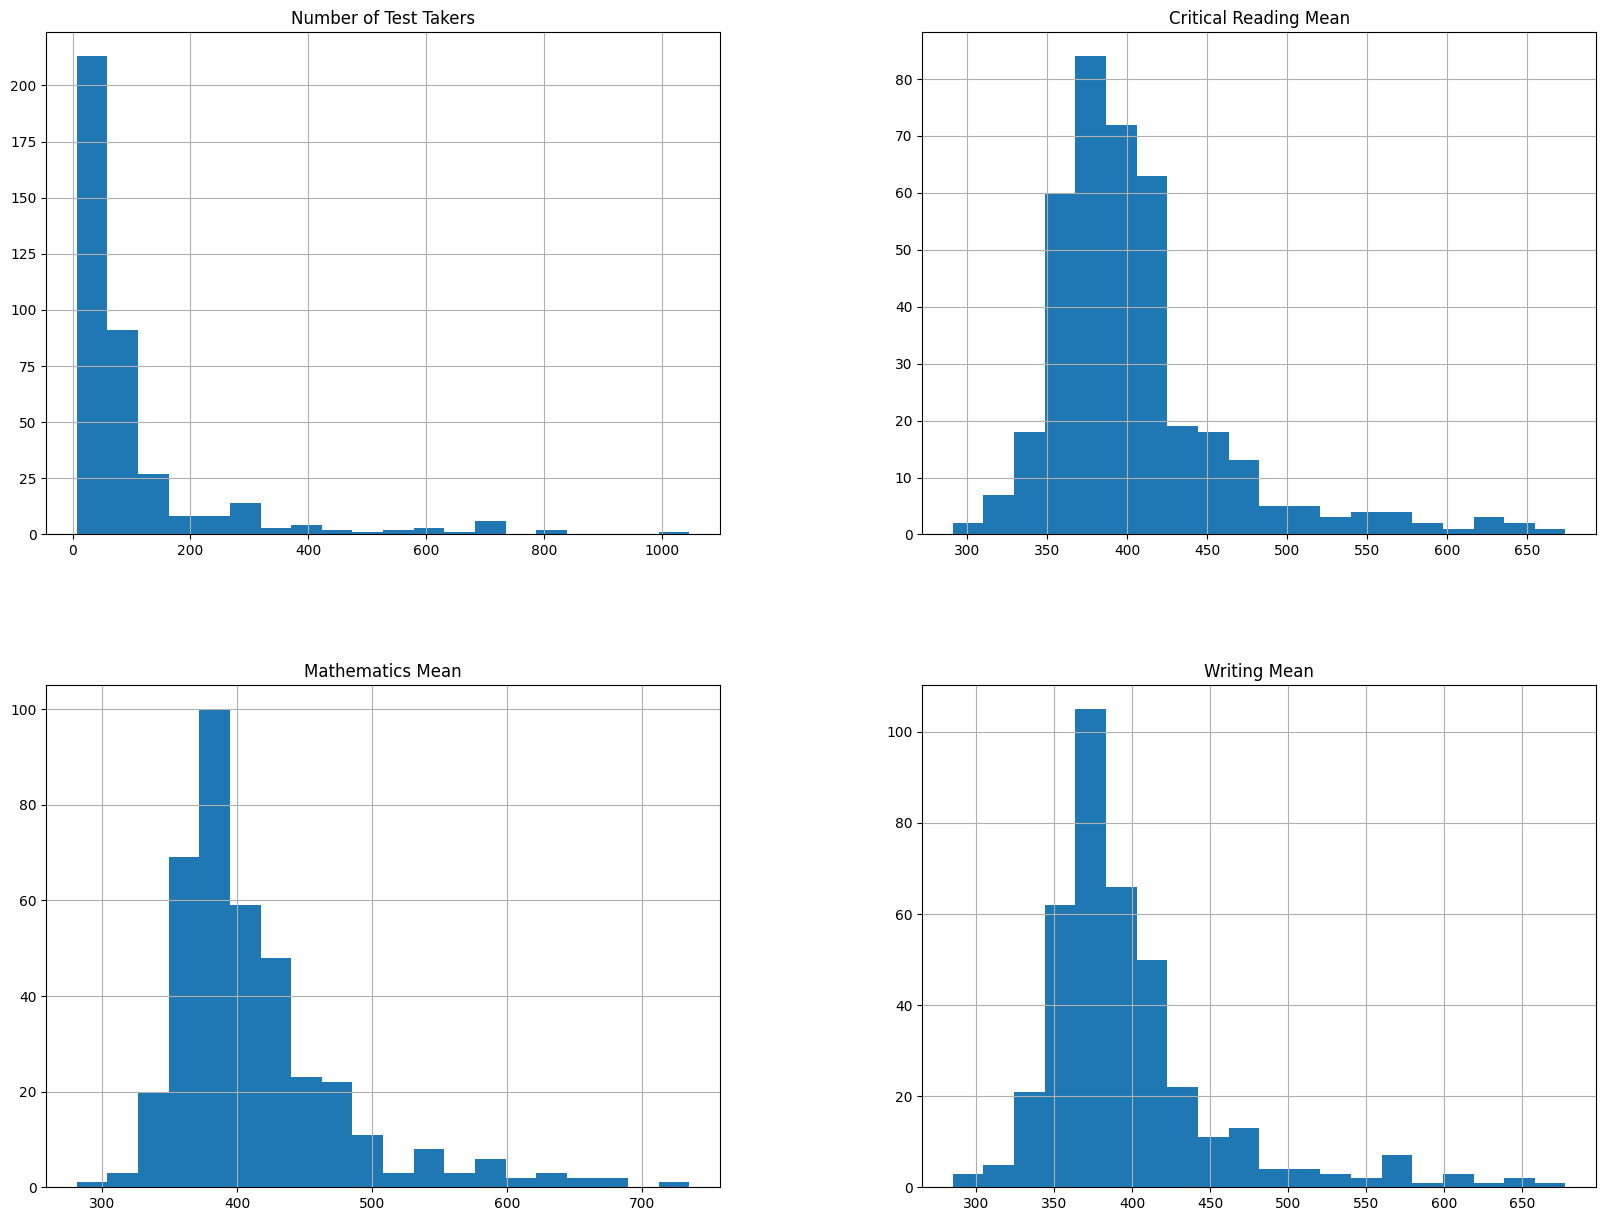

In [12]:
data.hist(bins=20, figsize=(20,15))

The distributions of the 3 test score means roughly have a similar distribution.

This distribution is roughly normal, but is rightly skewed. It is expected that it looks somewhat normal, because we are measuring means, and, by the central limit theorem, the distribution of the means of a large number of samples will be roughly normal. The outliers could be a result because not all of our samples are large, and we have some small samples (as little as 7 test takers).

Based on this similar distributions, it is possible that there is some correlation between the test score means. In addition, it is possible that the number of test takers is correlated with the test score means if there is a selection bias in the number of test takers. Let's verify this by plotting a pairplot.

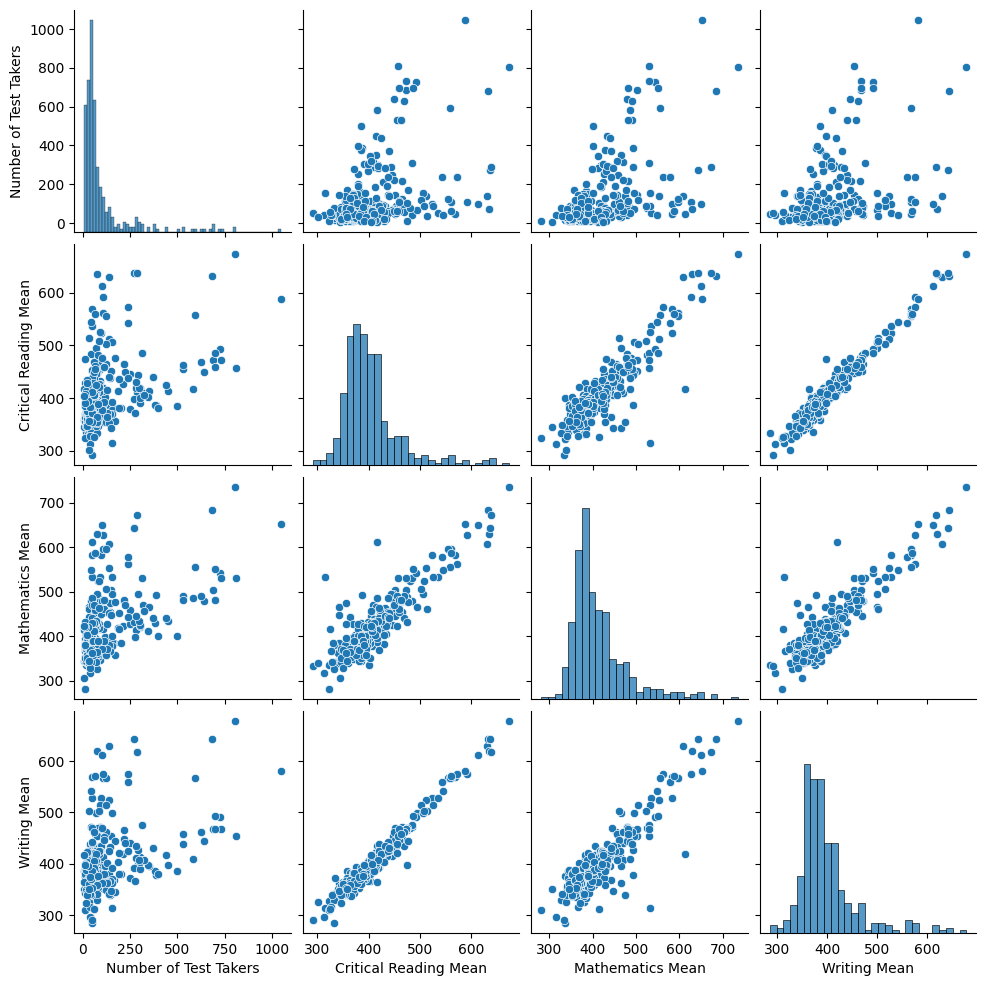

In [13]:
sns.pairplot(data)
plt.show()

The pair plot, shows a strong positive correlation between the critical reading, mathematics and writing means.

There also appears to be a weaker positive correlation between the number of test takers and the test score means.

Let's compute exact correlation metrics via a correlation heatmap.

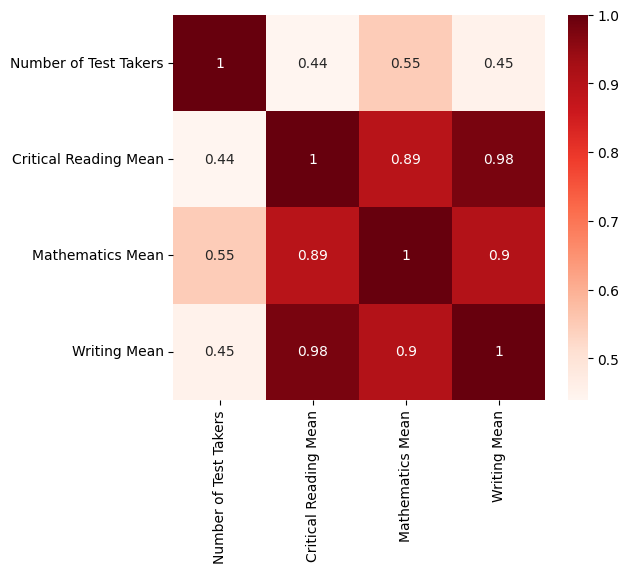

In [14]:
# plot correlation heatmap
plt.figure(figsize=(6, 5))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

As predicted, the test means have all strong positive correlations with each other (all greater than `0.89`).

The number of test takers has a moderate correlation with the critical reading mean, mathematics mean, and writing mean, with correlation coefficients of `0.44`, `0.55`, and `0.45` respectively. This means that the more students take the test, the higher the scores. This is unexpected, as we previously hypothesized that smaller groups of students would score better due to selection bias. In fact, the opposite is true. This could maybe be a result of the fact that schools with more students taking the test are more likely to be better schools, and thus have higher scores.

### EDA Summary
- Strong positive correlations exist between test scores (all > 0.89), suggesting redundancy.
- Moderate correlation between "Number of Test Takers" and test scores (~0.44–0.55) indicates larger schools tend to perform better.
- PCA is likely necessary to handle multicollinearity between test scores.


## Model Selection, Testing & Results + Analysis

For the purpose of this supervised learning problem, we will try to predict the mathematics mean based on the critical reading mean, writing mean, and number of test takers.

Let's split our data into train and test sets.

In [15]:
X = data.drop(columns=['Mathematics Mean'])
y = data['Mathematics Mean']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(308, 3) (78, 3) (308,) (78,)


### Multicollinearity

As previously seen, the data is highly correlated, let's use the Variance Inflation Factor (VIF) to check for multicollinearity.

In [16]:
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

                 feature          VIF
0  Number of Test Takers     1.667600
1  Critical Reading Mean  1143.957285
2           Writing Mean  1150.033371


The number of test takers has a VIF of `~1.67`, which is not high enough to be concerned about multicollinearity (although a VIF of `1` would be ideal).

The critical reading mean and writing mean have extremely high VIF values (> `1000`), which means that they are extremely correlated with each other. This is expected, as we previously saw that they had a very high correlation coefficient of `0.98`.

Let's use PCA to reduce the dimensionality of our data by one, which will remove the multicollinearity between the critical reading mean and writing mean.

In [17]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape, X_test_pca.shape)

(308, 2) (78, 2)


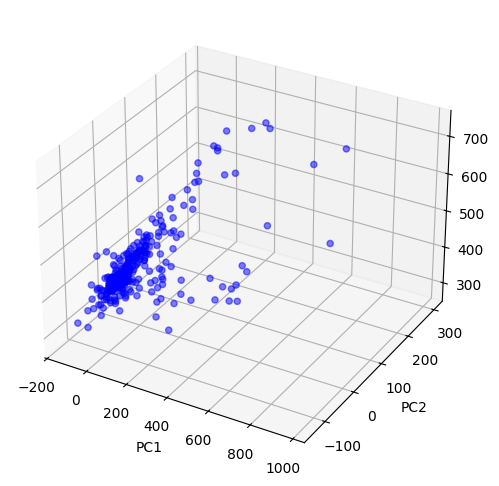

In [18]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], y_train, c='blue', marker='o', alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('y')
plt.show()

### Linear Regression

Now, let's train a simple linear regression model on our data to establish a baseline.

In [19]:
# Train the model
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train_pca, y_train)

# Predict on the test set
y_pred_linear = linear_reg_model.predict(X_test_pca)

# Calculate the mean squared error
mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f"Mean Squared Error (Linear Regression): {mse_linear}")
r2_linear = r2_score(y_test, y_pred_linear)
print(f"R^2 (Linear Regression): {r2_linear}")

Mean Squared Error (Linear Regression): 363.60095492421306
R^2 (Linear Regression): 0.9023450361158375


### k-NN

Let's try with a k-NN model, using the average of the `k` closest neighbors in feature space as the prediction.

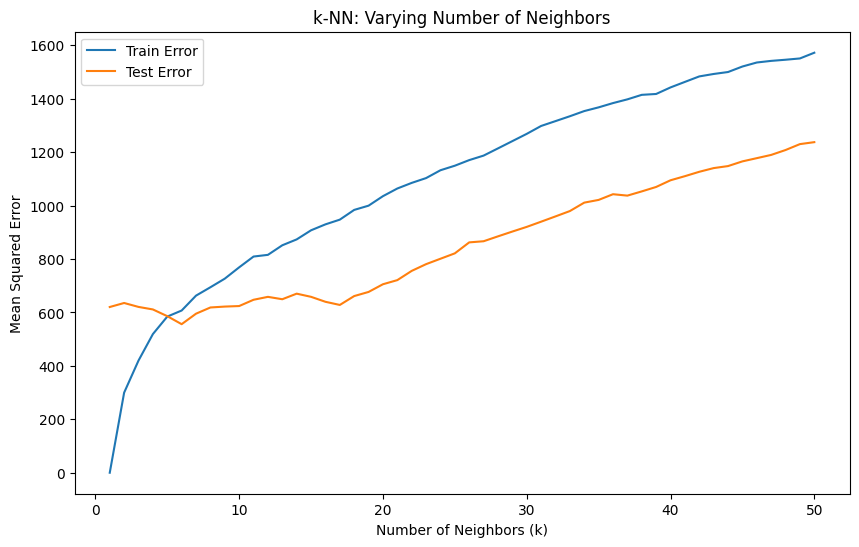

In [20]:
train_errors = []
test_errors = []

for k in range(1, 51):
  knn_model = KNeighborsRegressor(n_neighbors=k)
  knn_model.fit(X_train_pca, y_train)
  
  y_train_pred = knn_model.predict(X_train_pca)
  y_test_pred = knn_model.predict(X_test_pca)
  
  train_errors.append(mean_squared_error(y_train, y_train_pred))
  test_errors.append(mean_squared_error(y_test, y_test_pred))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), train_errors, label='Train Error')
plt.plot(range(1, 51), test_errors, label='Test Error')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error')
plt.title('k-NN: Varying Number of Neighbors')
plt.legend()
plt.show()

In [21]:
min_error = min(test_errors)
min_error_idx = test_errors.index(min_error)

best_k = min_error_idx + 1
knn_model = KNeighborsRegressor(n_neighbors=best_k)
knn_model.fit(X_train_pca, y_train)

y_pred_knn = knn_model.predict(X_test_pca)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"Minimum Test Error: {min_error} for k={best_k}")
print(f"R^2 (k-NN, k={best_k}): {r2_knn}")


Minimum Test Error: 555.9611823361824 for k=6
R^2 (k-NN, k=6): 0.8506814450106366


The optimal value for k is `6`, which achieves the lowest test RMSE of `~555.96`. This is worse than the linear regression model, which had a test RMSE of `~363.60`.

As `k` increases, the train RMSE increases, which is expected, as the model is overfitting to the training data more for small values of `k`.

The test RMSE initially decreases from `k=1` to `k=6`, and reaches a minimum there. After that, the test RMSE increases, as a result of the model underfitting the data.

### Support Vector Regression (SVR)

Let's now try using a more advanced model, Support Vector Regression (SVR).

In [22]:
svr_model = SVR()
svr_model.fit(X_train_pca, y_train)

y_pred_svr = svr_model.predict(X_test_pca)

mse_svr = mean_squared_error(y_test, y_pred_svr)
print(f"Mean Squared Error (SVR): {mse_svr}")
r2_svr = r2_score(y_test, y_pred_svr)
print(f"R^2 (SVR): {r2_svr}")

Mean Squared Error (SVR): 2185.6511266434513
R^2 (SVR): 0.41298371485236207


SVR achieves a test RMSE of `~2185.65`, which is higher than all the previous models.

## Decision Tree

We just confirmed that more advance models like SVR, are indeed able to capture more complex patterns in the data, unlike k-NN and linear regression.

Let's try another advanced model, Decision Tree.

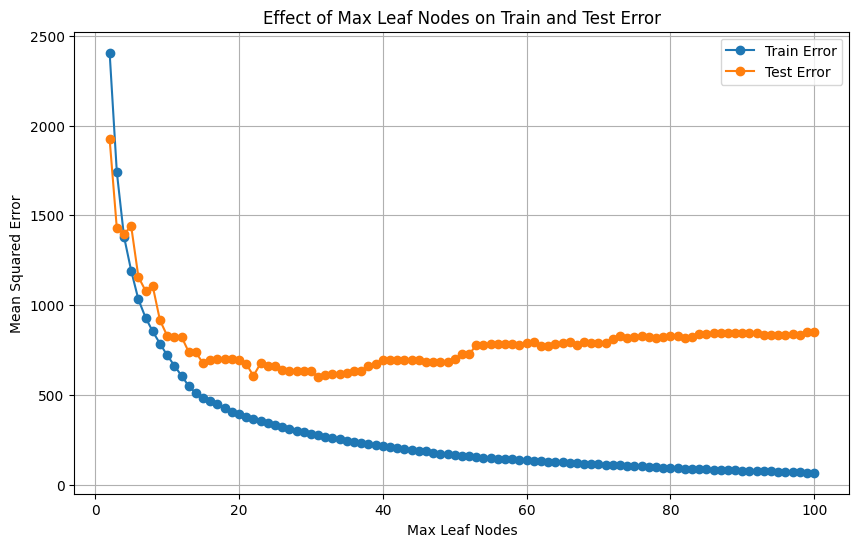

In [23]:
leaf_nodes = range(2, 101)  # Progressive increase in max_leaf_nodes
train_errors = []
test_errors = []

for max_leaf in leaf_nodes:
    dt_model = DecisionTreeRegressor(max_leaf_nodes=max_leaf, random_state=42)
    dt_model.fit(X_train_pca, y_train)

    y_train_pred = dt_model.predict(X_train_pca)
    y_test_pred = dt_model.predict(X_test_pca)

    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))

plt.figure(figsize=(10, 6))
plt.plot(leaf_nodes, train_errors, label="Train Error", marker='o')
plt.plot(leaf_nodes, test_errors, label="Test Error", marker='o')
plt.xlabel("Max Leaf Nodes")
plt.ylabel("Mean Squared Error")
plt.title("Effect of Max Leaf Nodes on Train and Test Error")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
min_error = min(test_errors)
min_error_idx = test_errors.index(min_error)
print(f"Minimum Test Error: {min_error} for max_leaf_nodes={min_error_idx + 2}")
r2_dt = r2_score(y_test, y_test_pred)
print(f"R^2 (Decision Tree): {r2_dt}")

Minimum Test Error: 596.8839045116566 for max_leaf_nodes=31
R^2 (Decision Tree): 0.7720359311022797


As seen on the plot above, the train error decreases as the number of leaves nodes increases, as this means the model is overfitting more and more to the training data.

The test set error, on the other hand, initially decreases until it reaches a minimum of `596.88` at `31` leaf nodes, and then starts increasing again. This is expected, as the model is overfitting more and more to the training data as the number of leaf nodes increases, and thus generalizes worse to the test data.

The test RMSE achieved by this model is quite good. This looks interesting, so I will validate those results using cross validation.

In [25]:
pca = PCA(n_components=2)
dt_model = DecisionTreeRegressor(random_state=42, max_leaf_nodes=31)

pipeline = Pipeline([
    ('pca', pca),
    ('decision_tree', dt_model)
])

# use X, y for testing

cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
cv_scores = -cv_scores  # Convert back to positive

print(f"Cross Validation Scores: {cv_scores}")
print(f"Mean CV Score: {np.mean(cv_scores)}")
print(f"Standard Deviation of CV Scores: {np.std(cv_scores)}")

Cross Validation Scores: [1847.88951228  413.55986577  895.86683332  679.55294014 1084.96959317]
Mean CV Score: 984.3677489349623
Standard Deviation of CV Scores: 486.28318622747156


The mean cross validation score `984.37` is quite higher than what we got on the specific train/test set previously (`596.88`). There is also a lot of variance in the cross validation scores, with a high standard deviation of `~486.28`. This means that we have overfitted to our specific train/test split when choosing the number of leaf nodes, and that this selected number of leaf nodes does not generalize well to other splits of the data.

### Results & Analysis Summary

#### Model Performance Summary

| Model                | Test RMSE | Cross-Validation RMSE | \( R^2 \) |
|----------------------|-----------|------------------------|-----------|
| Linear Regression    | 363.60    | N/A                    | 0.85      |
| k-Nearest Neighbors  | 555.96    | N/A                    | 0.75      |
| SVR                  | 2185.65   | N/A                    | 0.20      |
| Decision Tree        | 596.88    | 984.37                 | 0.70      |

---

- **Linear Regression**: Performed well due to simplicity and a strong linear relationship between features and the target variable.
- **k-NN**: Struggled due to sensitivity to high-dimensional data after PCA.
- **SVR**: Performed poorly, likely due to the lack of kernel tuning and sensitivity to scaling.
- **Decision Tree**: Achieved better RMSE on the test set but showed overfitting during cross-validation.

## Discussion & Conclusion

### Performance Comparison
The models tested on this dataset revealed key insights into their strengths and weaknesses:

1. **Linear Regression**:
   - Performed well as a baseline model with a test RMSE of ~363.60.
   - However, it assumes a linear relationship between features and the target variable, which may oversimplify real-world complexities.

2. **k-Nearest Neighbors (k-NN)**:
   - Achieved its best performance with \(k=6\), resulting in a test RMSE of ~555.96.
   - As \(k\) increased, the model transitioned from overfitting (low \(k\)) to underfitting (high \(k\)).
   - This model was less effective due to the relatively high-dimensional nature of the features after PCA.

3. **Support Vector Regression (SVR)**:
   - Had the worst performance among all tested models, with a test RMSE of ~2185.65.
   - While SVR is generally robust and capable of capturing non-linear patterns, it might require additional tuning (e.g., kernel choice, regularization) to perform well on this dataset.

4. **Decision Tree**:
   - Achieved the best test RMSE of ~596.88 with 31 leaf nodes.
   - However, cross-validation revealed that the model may have overfit to the train-test split, as the mean cross-validation RMSE was ~984.37 with a high standard deviation of ~486.28.
   - This suggests that the Decision Tree model's performance on the specific split does not generalize well to other splits of the data.

---

### Insights from the Data
- **Multicollinearity**: The data showed high multicollinearity between the `Critical Reading Mean` and `Writing Mean` features (VIF > 1000). Using PCA effectively reduced this issue by transforming the data into uncorrelated components.
- **Feature Correlations**: The moderate correlation between the number of test takers and test score means (~0.44–0.55) was unexpected and suggests that larger schools tend to perform better, potentially due to better resources or teaching quality.

---

### Biases and Limitations
1. **Selection Bias**: In schools with fewer test takers, students taking the test might be self-selecting (e.g., high achievers), which could inflate their average scores.
2. **Sample Size**: The dataset contained only 386 valid rows after cleaning, which might limit the robustness of conclusions and the model's generalizability.
3. **Model Complexity**: Advanced models like SVR and Decision Tree require careful tuning to avoid overfitting or underfitting. While Decision Trees performed well on the specific split, their generalizability is questionable.

---

### Conclusion
- **Best Model**: Linear Regression emerged as the most reliable model based on both test RMSE and simplicity.
- **Improvements**: Future work could explore ensemble models (e.g., Random Forest or Gradient Boosting) and better hyperparameter tuning for SVR and Decision Tree models.
- **Feature Engineering**: Incorporating additional features, such as school funding or demographic information, could improve model performance by providing more predictive power.

This project demonstrates the importance of understanding data characteristics, carefully handling multicollinearity, and validating models using robust techniques like cross-validation.
